In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [1]:
!pip install shap
!pip install bayesian-optimization
!pip install lightgbm

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('/gdrive/My Drive/Data/train.csv', index_col=0)
test = pd.read_csv('/gdrive/My Drive/Data/test.csv', index_col=0)
sample_submission = pd.read_csv('/gdrive/My Drive/Data/sample_submission.csv', index_col=0)
scaler = RobustScaler()

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)
train.describe()


,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,type_num
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281,8.877339
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138,4.624156
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196,0.000000
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774,6.000000
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997,8.000000
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554,11.000000
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172,18.000000


In [24]:
train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -3000]
train_k1 = train1[train1[feature_col] > 1000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)
train.describe()

,type_num,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000,199961.000000
mean,8.877386,360.835453,20.984809,19.863223,19.280856,18.877075,18.612496,21.175120,20.089969,19.505003,19.087038,18.827907,20.709374,19.592834,19.001273,18.603487,18.405561,20.732513,19.532383,18.940854,18.521157,18.277713
std,4.624172,225.312297,2.879893,2.301657,2.647863,2.102330,1.764674,2.180940,1.846938,1.708515,1.626544,1.759496,5.184125,5.222059,7.707273,2.755425,5.009142,2.188580,1.964419,1.862421,1.798753,1.869048
min,0.000000,1.000000,-501.529124,-335.608609,-619.353582,-30.711890,-106.927107,-68.798881,-8.294703,-14.662435,10.646672,-139.831165,-1131.081339,-1581.627834,-2998.277036,-654.195115,-789.601838,3.444448,8.686690,5.781584,5.004407,4.460086
25%,6.000000,174.000000,19.652900,18.701826,18.048916,17.748122,17.425886,19.941176,18.903412,18.259624,17.904007,17.606638,19.248125,18.114249,17.480168,17.050727,16.805081,19.266446,18.076413,17.423702,16.977844,16.705951
50%,8.000000,349.000000,20.871475,19.904295,19.454579,19.044094,18.611941,21.049322,20.069257,19.631853,19.189131,18.711158,20.366919,19.586778,19.182990,18.693748,18.174806,20.406920,19.547798,19.143344,18.641862,18.101192
75%,11.000000,526.000000,22.160381,21.150391,20.515942,20.073678,19.883806,22.337744,21.386006,20.773954,20.331486,20.133244,21.797459,21.004393,20.457461,20.019139,19.807617,21.992889,20.962267,20.408121,19.968855,19.819559
max,18.000000,1000.000000,368.939515,478.440761,117.565177,585.370349,115.830481,274.083693,68.509385,32.574603,42.002047,173.583776,667.792296,773.346459,809.628220,219.701423,907.434571,49.487277,66.589958,35.102312,45.783550,61.597879


In [25]:
train2 = train[["fiberID","type_num"]]
train2["count"] =1
train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
train2_g.fillna(0,inplace=True)
for i in range(train2_g.shape[0]):
    for j in range(train2_g.shape[1]):
        if train2_g.iloc[i,j]!=0:
            train2_g.iloc[i,j] = 1
train2_g = train2_g.reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
train = train.reset_index().merge(train2_g,on="fiberID").set_index("index").sort_index().drop("fiberID",axis=1)
test = test.reset_index().merge(train2_g,on="fiberID").set_index("id").sort_index().drop("fiberID",axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [0]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# train["code"] = encoder.fit_transform(train["code"])
# test["code"] = encoder.transform(test["code"])

train_x = train.drop('type_num', axis=1)
train_y = train['type_num']
test_x = test
set_data = pd.concat([train_x,test_x],axis=0)

# set_du = pd.get_dummies(set_data["code"], prefix="code")
# set_data.drop("code",axis=1,inplace=True)
# set_data1 = pd.concat([set_data,set_du],axis=1)
train_x = set_data.iloc[:199961,:]
test_x = set_data.iloc[199961:,:]

In [0]:
sc_col = train_x.iloc[:,:20].columns
not_col = train_x.columns.difference(sc_col)
tr_ind =  train_x.index
te_ind = test_x.index

In [0]:
train_x_sc = scaler.fit_transform(train_x[sc_col])
test_x_sc = scaler.transform(test_x[sc_col])
train_x_sc =  pd.DataFrame(train_x_sc,columns = sc_col,index = tr_ind)
test_x_sc =  pd.DataFrame(test_x_sc,columns = sc_col,index = te_ind)
# set_sc = scaler.fit_transform(set_data1[sc_col])
# set_sc =  pd.DataFrame(set_sc,columns = sc_col,index = set_data1.index)
# set_data2 = pd.concat([set_sc,set_data1[not_col]],axis=1)
# train_x = set_data2.iloc[:199961,:]
# test_x = set_data2.iloc[199961:,:]

train_x = pd.concat([train_x_sc,train_x[not_col]],axis=1)
test_x = pd.concat([test_x_sc,test_x[not_col]],axis=1)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_x_sc, train_y):
    x_train, y_train = train_x.loc[train_index], train_y[train_index]
    x_val, y_val = train_x.loc[test_index] , train_y[test_index]

In [10]:
train_y[1]

8

In [38]:
# from sklearn.decomposition import PCA
# pca = PCA()
# train_x = set_data1.iloc[:199961,:]
# test_x = set_data1.iloc[199961:,:]

# train_x_pc = pca.fit_transform(train_x[sc_col])
# test_x_pc = pca.transform(test_x[sc_col])
# train_x_pc =  pd.DataFrame(train_x_pc, index = tr_ind)
# test_x_pc =  pd.DataFrame(test_x_pc,index = te_ind)

# train_x = pd.concat([train_x_pc,train_x[not_col]],axis=1)
# test_x = pd.concat([test_x_pc,test_x[not_col]],axis=1)
train_y1 = train_y
for i in range(len(train_y)):
  if train_y[i] == 0:
    train_y1[i] = 1
  else:
    train_y1[i] = 0
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_x, train_y1):
    x_train, y_train = train_x.loc[train_index], train_y1[train_index]
    x_val, y_val = train_x.loc[test_index] , train_y1[test_index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=70, max_depth=-1, learning_rate=0.002, 
                             n_estimators=15000, subsample_for_bin=300000, objective='binary', min_split_gain=0.2, 
                             min_child_weight=5e-2, min_child_samples=12,n_jobs=-1, random_state=42, class_weight='balanced',reg_alpha=0.05 )
lgb_model = lgb_clf.fit(x_train,y_train)

In [0]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
encoder1 = OneHotEncoder()
y_en = encoder1.fit_transform(np.array(y_val).reshape(-1,1))

In [51]:
y_preds = lgb_model.predict_proba(x_val)
log_loss(y_en.toarray(),y_preds)

0.40071202184688565

[Text(0, 0, 'petroMag_u'),
 Text(0, 0, 'petroMag_z'),
 Text(0, 0, 'psfMag_u'),
 Text(0, 0, 'modelMag_u'),
 Text(0, 0, 'fiberMag_u'),
 Text(0, 0, 'psfMag_z'),
 Text(0, 0, 'fiberMag_z'),
 Text(0, 0, 'modelMag_z'),
 Text(0, 0, 'psfMag_g'),
 Text(0, 0, 'psfMag_i'),
 Text(0, 0, 'psfMag_r'),
 Text(0, 0, 'fiberMag_g'),
 Text(0, 0, 'petroMag_g'),
 Text(0, 0, 'fiberMag_i'),
 Text(0, 0, 'modelMag_g'),
 Text(0, 0, 'fiberMag_r'),
 Text(0, 0, 'petroMag_i'),
 Text(0, 0, 'modelMag_i'),
 Text(0, 0, 'petroMag_r'),
 Text(0, 0, 'modelMag_r'),
 Text(0, 0, 'code_12'),
 Text(0, 0, 'code_0'),
 Text(0, 0, 'code_27'),
 Text(0, 0, 'code_13'),
 Text(0, 0, 'code_10'),
 Text(0, 0, 'code_25'),
 Text(0, 0, 'code_28'),
 Text(0, 0, 'code_18'),
 Text(0, 0, 'code_19'),
 Text(0, 0, 'code_20'),
 Text(0, 0, 'code_34'),
 Text(0, 0, 'code_33'),
 Text(0, 0, 'code_14'),
 Text(0, 0, 'code_26'),
 Text(0, 0, 'code_29'),
 Text(0, 0, 'code_5'),
 Text(0, 0, 'code_4'),
 Text(0, 0, 'code_32'),
 Text(0, 0, 'code_30'),
 Text(0, 0, 'code

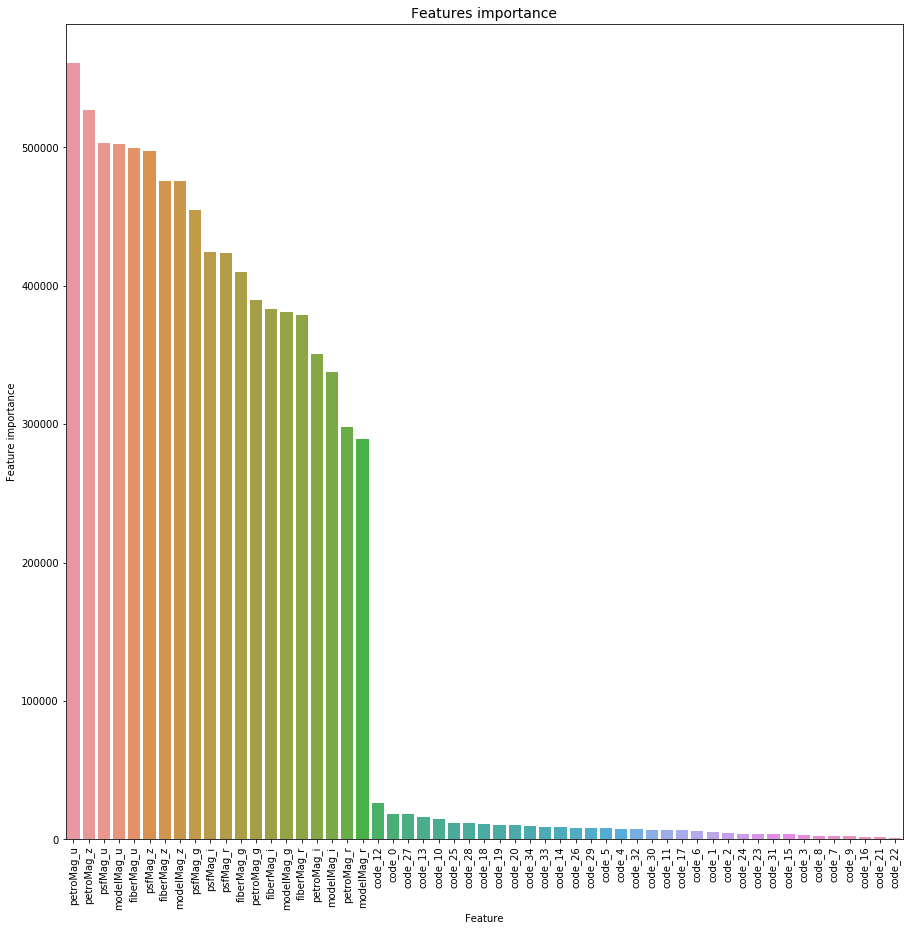

In [64]:
tmp = pd.DataFrame({'Feature': x_train.columns, 'Feature importance': lgb_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

In [0]:
predictions = lgb_model.predict(x_val)

In [0]:
from sklearn.mixture import GaussianMixture
gp = GaussianMixture(n_components=3).fit(train_x)

In [0]:
tex = pd.DataFrame(gp.predict_proba(train_x))

In [0]:
tex1 = pd.concat([train_x_sc,tex],axis=1)
split = StratifiedShuffleSplit(test_size=0.2, random_state=42)

for train_index, test_index in split.split(tex1, train_y):
    x_train, y_train = tex1.loc[train_index], train_y[train_index]
    x_val, y_val = tex1.loc[test_index] , train_y[test_index]

In [0]:
gp_model = gp.fit(x_train, y_train)

In [0]:
y_pred = clf.pred

In [46]:
from sklearn.metrics import classification_report
classification_report(y_val, predictions)

'              precision    recall  f1-score   support\n\n           0       1.00      0.99      0.99     39561\n           1       0.36      0.71      0.48       432\n\n    accuracy                           0.98     39993\n   macro avg       0.68      0.85      0.74     39993\nweighted avg       0.99      0.98      0.99     39993\n'

In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE('minority',random_state=42,ratio = 0.3)
x_sm, y_sm = smote.fit_sample(x_train,y_train)
lgb_clf1 = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=70, max_depth=-1, learning_rate=0.005, 
                             n_estimators=5000, subsample_for_bin=300000, objective='binary', min_split_gain=0.2, reg_alpha = 0.1 
                             min_child_weight=5e-2, min_child_samples=12,n_jobs=-1, random_state=42,class_weight=True,)
lgb_model1 = lgb_clf1.fit(x_sm,y_sm)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
y_preds = lgb_model1.predict_proba(x_val)
log_loss(y_en.toarray(),y_preds)

0.05313488951699025

In [1]:
from sklearn.metrics import confusion_matrix
y_pred1 = lgb_model.predict(x_val)
confusion_matrix(y_val, y_pred1)
import seaborn as sns
plt.figure(figsize=(15,15))
plt.xlabel("val")
ax = sns.heatmap(confusion_matrix(y_val, y_pred1), annot=True, fmt="d" ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns)

NameError: ignored

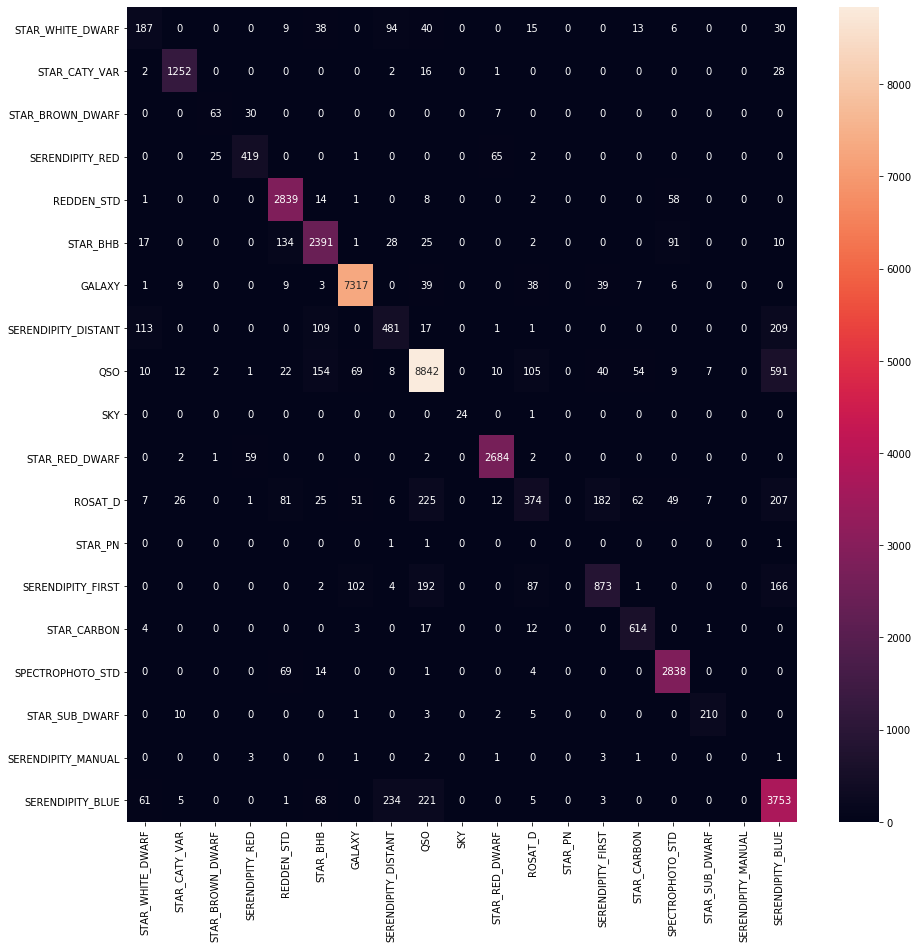

In [0]:
import seaborn as sns
plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix(y_val, y_pred1), annot=True, fmt="d" ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns)

In [0]:
y_test = lgb_model1.predict_proba(test_x)

In [0]:
submission = pd.DataFrame(data=y_test, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('/gdrive/My Drive/Data/submission4.csv', index=True)

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=600,
                          max_depth=15,
                          min_samples_split=4,
                          min_samples_leaf=4,
                          max_features=None,
                          oob_score=True,
                          random_state=42)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
y_preds = rf_clf.predict_proba(x_val)
log_loss(y_en.toarray(),y_preds)

0.4134253290376

In [0]:
import shap
explainer = shap.TreeExplainer(lgb_clf) 
shap_values = explainer.shap_values(x_val)
shap.initjs() 

shap.force_plot(explainer.expected_value, shap_values[1,:], x_val.iloc[1,:]) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


JSONDecodeError: ignored

In [0]:
shap.summary_plot(shap_values, x_val)

In [0]:
import sklearn.metrics import logloss
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_en = encoder.fit_transform(np.array(y_val).reshape(-1,1))
y_pred = forest.predict_proba(x_val)
log_loss(y_en.toarray(),y_pred)

In [0]:
def build_model(sub_sample_for_bin1, learning_rate1, num_leaves1, max_depth1,min_child_weight1, min_data_in_leaf1, min_split_gain1, min_child_samples1):
  model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=num_leaves1,  min_split_gain=  min_split_gain1,
                               min_data_in_leaf = min_data_in_leaf1,
                               class_weight = 'balanced',
                               max_depth= max_depth1, learning_rate=learning_rate1, n_estimators=10000, 
                               subsample_for_bin=sub_sample_for_bin1, objective='multiclass', 
                               min_child_weight=min_child_weight1, min_child_samples=min_child_samples1
                               ,n_jobs=-1, random_state=42)
  return model
def learning_rate_001_decay_power_099(current_iter):
    base_learning_rate = 0.01
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [0]:

def fit_with(learning_rate1, num_leaves1, max_depth1,min_child_weight1, min_data_in_leaf1, min_split_gain1,min_child_samples1):
    model = build_model(400000, learning_rate1,int(num_leaves1), int(max_depth1),min_child_weight1, int(min_data_in_leaf1), min_split_gain1,int(min_child_samples1))
    fit_model = model.fit(x_train,y_train,eval_set = [(x_val,y_val)], verbose= 500,
                          early_stopping_rounds=1000)
    y_pred = model.predict_proba(x_val)
    
    return -log_loss(y_en.toarray(),y_pred)

# from functools import partial

# verbose = 1
# fit_with_partial = partial(fit_with, verbose)

In [0]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'learning_rate1' : (1e-4,1e-2),
    'num_leaves1':  (5, 50),
    'max_depth1': (10, 30),
    'min_child_weight1': (0.001, 1),                                              
    'min_child_samples1' : (10, 30),
    'min_data_in_leaf1' : (1,10),
    'min_split_gain1' : (0.1,0.5),
}

bayes_optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    # random_state=1
)

bayes_optimizer.maximize(init_points=15, n_iter=15)
for i, res in enumerate(bayes_optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   | learni... | max_de... | min_ch... | min_ch... | min_da... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's multi_logloss: 0.66506
[1000]	valid_0's multi_logloss: 0.4502
[1500]	valid_0's multi_logloss: 0.395976
[2000]	valid_0's multi_logloss: 0.377678
[2500]	valid_0's multi_logloss: 0.369624
[3000]	valid_0's multi_logloss: 0.365902
Did not meet early stopping. Best iteration is:
[3000]	valid_0's multi_logloss: 0.365902
|  1        | -0.3659   |  0.003472 |  14.46    |  15.01    |  0.7299   |  6.205    |  0.4502   |  44.42    |
Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's multi_logloss: 0.413302
[1000]	valid_0's multi_logloss: 0.369813
[1500]	valid_0's multi_logloss: 0.36268
[2000]	valid_0's multi_logloss: 0.359679
[2500]	valid_0's multi_logloss: 0.358211
[3000]	v

In [0]:
n_estimators = [100, 1000]
l_rate = [0.01,0.01]
run_gbt_model(n_estimators, l_rate)

---------- n_estimators : 100, learning_rate : 0.01 ----------


In [0]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import KFold

# log_clf = LogisticRegression(solver='saga', random_state=42)
# rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42)
# svm_clf = SVC(gamma='auto', probability=True, random_state=42)

# voting_clf = VotingClassifier(
#     estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
#     voting='soft')
# voting_clf.fit(x_train, y_train)

In [0]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
lgb_param = {'boosting_type':'gbdt',
             'num_leaves': 30,
             'max_depth': -1,
            'learning_rate': 0.0075, 
            'bagging_fraction' : 1,
            'max_bin' : 5000 ,
            'bagging_freq': 20,
            'colsample_bytree': 0.6,
             'objective': 'multiclass', 
            'num_class': len(set(y_train)) + 1,
             'metric': 'multi_logloss',
             'min_split_gain': 0.5,
            'min_child_weight': 1,
            'min_child_samples': 10,
            'scale_pos_weight':1,
            'zero_as_missing': True,
            }
lgb_clf = LGBMClassifier(params = lgb_param)
rf_clf = RandomForestClassifier(n_estimators=500,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [0]:
stack_gen = StackingCVClassifier(classifiers=(xgb_clf, lgb_clf, svm_clf, rf_clf),
                                 meta_classifier = lgb_clf,
                                use_features_in_secondary=True,cv=5)

In [0]:
stack_gen_model = stack_gen.fit(np.array(x_train),np.array(y_train))

In [0]:
model1 = build_model(400000, 0.008, 45, -1 ,0.15, 5, 0.22, 12)

In [0]:
from sklearn.utils import class_weight
weight = class_weight.compute_class_weight('balanced',np.unique(train_y),train_y)

In [0]:

fit_model = model1.fit(x_train,y_train,eval_set = [(x_val,y_val)], eval_metric='logloss', verbose= 500,
                          early_stopping_rounds=3000)
y_pred = model1.predict_proba(x_val)
    
log_loss(y_en.toarray(),y_pred)

Training until validation scores don't improve for 3000 rounds.
[500]	valid_0's multi_logloss: 0.521833	valid_0's multi_logloss: 0.521833
[1000]	valid_0's multi_logloss: 0.446226	valid_0's multi_logloss: 0.446226
[1500]	valid_0's multi_logloss: 0.427653	valid_0's multi_logloss: 0.427653
[2000]	valid_0's multi_logloss: 0.418552	valid_0's multi_logloss: 0.418552
[2500]	valid_0's multi_logloss: 0.413378	valid_0's multi_logloss: 0.413378


KeyboardInterrupt: ignored